## imports

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

Using device: cpu


## Loading required data and transformations

In [33]:
df = pd.read_csv('cleaned_data/updated_over_by_over_data_set.csv')

df['season'] = df['season'].astype(str)
df['season_year'] = df['season'].apply(lambda x: int(x.split('/')[0]))
max_year = 2024
df['season_weight'] = np.exp(-0.1 * (max_year - df['season_year']))

# Encode teams using LabelEncoder + Embedding
team_encoder = LabelEncoder()
df['batting_team'] = team_encoder.fit_transform(df['batting_team'])
df['bowling_team'] = team_encoder.fit_transform(df['bowling_team'])

# Numerical features
numerical_features = ['over', 'run_rate', 'req_runrate', 'target_left', 'season_weight']
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[numerical_features])

# Step 3: Split the dataset into train and test (by match_id)
match_ids = df['match_id'].unique()
train_match_ids, test_match_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_df = df[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
test_df = df[df['match_id'].isin(test_match_ids)].reset_index(drop=True)

# Prepare numerical data for train and test sets
train_numerical_data = scaler.transform(train_df[numerical_features])
test_numerical_data = scaler.transform(test_df[numerical_features])

# Create index mappings for train and test DataFrames
train_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(train_df.index)}
test_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(test_df.index)}


## Training Model

In [34]:
class IPLDataset(Dataset):
    def __init__(self, df, numerical_data, index_map):
        self.df = df
        self.numerical_data = numerical_data
        self.index_map = index_map
        self.matches = []

        for match_id in df['match_id'].unique():
            for inning in [1, 2]:
                match_inning = df[(df['match_id'] == match_id) & (df['inning'] == inning)]
                if len(match_inning) > 1:
                    self.matches.append(match_inning.reset_index(drop=True))

    def __len__(self):
        return sum(len(match) - 1 for match in self.matches)

    def __getitem__(self, idx):
        cum_idx = 0
        for match in self.matches:
            match_len = len(match) - 1
            if cum_idx + match_len > idx:
                over_idx = idx - cum_idx
                sequence = match.iloc[:over_idx + 1]
                next_row = match.iloc[over_idx + 1]
                break
            cum_idx += match_len

        team1_seq = torch.tensor(sequence['batting_team'].values, dtype=torch.long)
        team2_seq = torch.tensor(sequence['bowling_team'].values, dtype=torch.long)

        numerical_seq = torch.tensor([
            self.numerical_data[self.index_map[sequence.index[i]]]
            for i in range(len(sequence))
        ], dtype=torch.float32)

        runs = torch.tensor(next_row['total_runs'], dtype=torch.float32)
        wickets = torch.tensor(next_row['is_wicket'], dtype=torch.float32)

        return team1_seq, team2_seq, numerical_seq, runs, wickets


In [35]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    team1_seqs, team2_seqs, num_seqs, runs, wickets = zip(*batch)

    team1_seqs = pad_sequence(team1_seqs, batch_first=True, padding_value=0)
    team2_seqs = pad_sequence(team2_seqs, batch_first=True, padding_value=0)
    num_seqs = pad_sequence(num_seqs, batch_first=True, padding_value=0.0)

    runs = torch.stack(runs)
    wickets = torch.stack(wickets)

    return team1_seqs, team2_seqs, num_seqs, runs, wickets


In [36]:
train_dataset = IPLDataset(train_df, train_numerical_data, train_index_map)
test_dataset = IPLDataset(test_df, test_numerical_data, test_index_map)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)



## Model Architecture

In [37]:
class IPLModel(nn.Module):
    def __init__(self, num_teams, embedding_dim, numerical_dim, hidden_dim):
        super(IPLModel, self).__init__()
        self.team_embedding = nn.Embedding(num_teams, embedding_dim)
        self.lstm = nn.LSTM(input_size=2*embedding_dim + numerical_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc_runs = nn.Linear(hidden_dim, 1)
        self.fc_wickets = nn.Linear(hidden_dim, 1)

    def forward(self, team1_seq, team2_seq, num_seq):
        team1_emb = self.team_embedding(team1_seq)  # (batch_size, seq_len, emb_dim)
        team2_emb = self.team_embedding(team2_seq)  # (batch_size, seq_len, emb_dim)
        x = torch.cat([team1_emb, team2_emb, num_seq], dim=2)  # (batch_size, seq_len, 2*emb_dim + num_dim)
        lstm_out, _ = self.lstm(x)
        out_runs = self.fc_runs(lstm_out[:, -1, :])  # only use final timestep
        out_wickets = self.fc_wickets(lstm_out[:, -1, :])
        return out_runs.squeeze(1), out_wickets.squeeze(1)


## Training and Validation Loop

Epoch 1/10:
Train Loss: 25.6746, Test Loss: 21.6494
Train Runs MAE: 3.9218, Test Runs MAE: 3.6923
Train Wickets MAE: 0.4519, Test Wickets MAE: 0.4495
Best model saved with Test Loss: 21.6494
Epoch 2/10:
Train Loss: 22.0598, Test Loss: 21.5883
Train Runs MAE: 3.6932, Test Runs MAE: 3.6907
Train Wickets MAE: 0.4548, Test Wickets MAE: 0.4427
Best model saved with Test Loss: 21.5883
Epoch 3/10:
Train Loss: 21.8670, Test Loss: 21.1711
Train Runs MAE: 3.6738, Test Runs MAE: 3.6578
Train Wickets MAE: 0.4452, Test Wickets MAE: 0.3982
Best model saved with Test Loss: 21.1711
Epoch 4/10:
Train Loss: 21.5134, Test Loss: 21.0156
Train Runs MAE: 3.6471, Test Runs MAE: 3.6146
Train Wickets MAE: 0.4322, Test Wickets MAE: 0.4152
Best model saved with Test Loss: 21.0156
Epoch 5/10:
Train Loss: 21.4337, Test Loss: 20.9465
Train Runs MAE: 3.6404, Test Runs MAE: 3.6061
Train Wickets MAE: 0.4346, Test Wickets MAE: 0.4412
Best model saved with Test Loss: 20.9465
Epoch 6/10:
Train Loss: 21.4123, Test Loss: 2

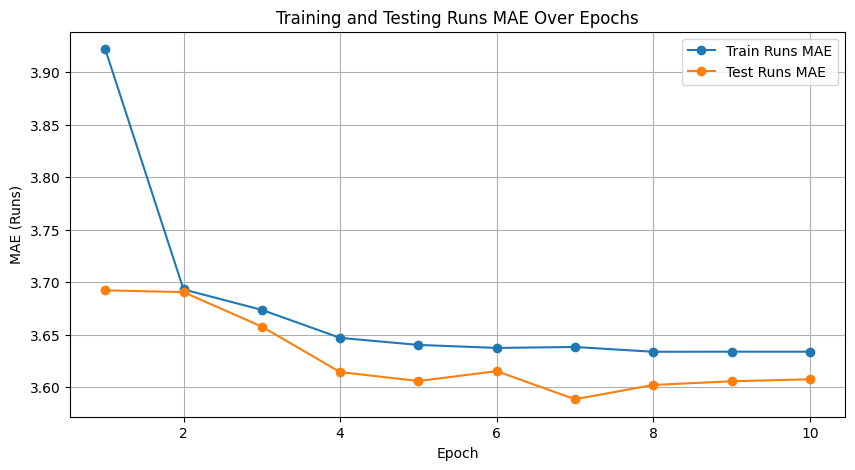

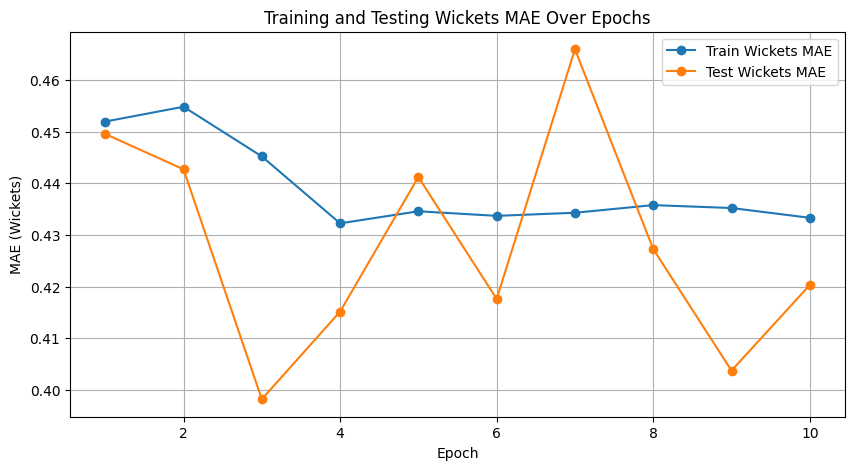

Plots saved as 'loss_over_epochs.png', 'runs_mae_over_epochs.png', and 'wickets_mae_over_epochs.png'


In [38]:
num_teams = len(team_encoder.classes_)
model = IPLModel(num_teams=num_teams, embedding_dim=10, numerical_dim=len(numerical_features), hidden_dim=32)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Lists to store metrics for plotting
train_losses = []
test_losses = []
train_runs_mae = []
test_runs_mae = []
train_wickets_mae = []
test_wickets_mae = []
best_test_loss = float("inf")

num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_r_mae = 0
    train_w_mae = 0
    for team1_seq, team2_seq, num_seq, runs, wickets in train_loader:
        team1_seq, team2_seq, num_seq = team1_seq.to(device), team2_seq.to(device), num_seq.to(device)
        runs, wickets = runs.to(device), wickets.to(device)

        optimizer.zero_grad()
        pred_runs, pred_wickets = model(team1_seq, team2_seq, num_seq)
        loss_runs = criterion(pred_runs, runs)
        loss_wickets = criterion(pred_wickets, wickets)
        loss = loss_runs + loss_wickets
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r_mae += torch.mean(torch.abs(pred_runs - runs)).item()
        train_w_mae += torch.mean(torch.abs(pred_wickets - wickets)).item()

    train_losses.append(train_loss / len(train_loader))
    train_runs_mae.append(train_r_mae / len(train_loader))
    train_wickets_mae.append(train_w_mae / len(train_loader))

    # Testing phase
    model.eval()
    test_loss = 0
    test_r_mae = 0
    test_w_mae = 0
    with torch.no_grad():
        for team1_seq, team2_seq, num_seq, runs, wickets in test_loader:
            team1_seq, team2_seq, num_seq = team1_seq.to(device), team2_seq.to(device), num_seq.to(device)
            runs, wickets = runs.to(device), wickets.to(device)
            pred_runs, pred_wickets = model(team1_seq, team2_seq, num_seq)
            loss_runs = criterion(pred_runs, runs)
            loss_wickets = criterion(pred_wickets, wickets)
            loss = loss_runs + loss_wickets
            test_loss += loss.item()
            test_r_mae += torch.mean(torch.abs(pred_runs - runs)).item()
            test_w_mae += torch.mean(torch.abs(pred_wickets - wickets)).item()
    test_losses.append(test_loss / len(test_loader))
    test_runs_mae.append(test_r_mae / len(test_loader))
    test_wickets_mae.append(test_w_mae / len(test_loader))

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    print(f"Train Runs MAE: {train_runs_mae[-1]:.4f}, Test Runs MAE: {test_runs_mae[-1]:.4f}")
    print(f"Train Wickets MAE: {train_wickets_mae[-1]:.4f}, Test Wickets MAE: {test_wickets_mae[-1]:.4f}")

    # Save best model
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        torch.save(model.state_dict(), 'best_ipl_model.pth')
        print(f"Best model saved with Test Loss: {best_test_loss:.4f}")
    if device.type == 'cuda':
        print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
epochs = range(1, num_epochs + 1)
# Plot 1: Training vs Testing Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('loss_over_epochs.png')
plt.close()

# Plot 2: Training vs Testing Runs MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_mae, label='Train Runs MAE', marker='o')
plt.plot(epochs, test_runs_mae, label='Test Runs MAE', marker='o')
plt.title('Training and Testing Runs MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (Runs)')
plt.legend()
plt.grid(True)
plt.savefig('runs_mae_over_epochs.png')
plt.show()
plt.close()

# Plot 3: Training vs Testing Wickets MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_wickets_mae, label='Train Wickets MAE', marker='o')
plt.plot(epochs, test_wickets_mae, label='Test Wickets MAE', marker='o')
plt.title('Training and Testing Wickets MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (Wickets)')
plt.legend()
plt.grid(True)
plt.savefig('wickets_mae_over_epochs.png')
plt.show()
plt.close()

print("Plots saved as 'loss_over_epochs.png', 'runs_mae_over_epochs.png', and 'wickets_mae_over_epochs.png'")

# Load the best model for inference

In [39]:

print("\n📥 Loading best model for evaluation...")
model.load_state_dict(torch.load('best_ipl_model.pth'))
model.eval()


📥 Loading best model for evaluation...


IPLModel(
  (team_embedding): Embedding(14, 10)
  (lstm): LSTM(25, 32, batch_first=True)
  (fc_runs): Linear(in_features=32, out_features=1, bias=True)
  (fc_wickets): Linear(in_features=32, out_features=1, bias=True)
)

## Simulating the cricket phase

In [40]:
# def simulate_match(model, team_encoder, scaler, device):
#     model.eval()
#     valid_teams = list(team_encoder.classes_)
#     print("\nAvailable teams:", valid_teams)

#     # 1. Get user input
#     batting_team = input("Batting team: ").strip()
#     bowling_team = input("Bowling team: ").strip()
#     if batting_team not in valid_teams or bowling_team not in valid_teams:
#         print("❌ Invalid team names.")
#         return
    
#     try:
#         innings = int(input("Which innings? (1 or 2): "))
#         current_over = int(input("Current completed over (e.g., 5): "))
#         current_runs = int(input("Current total runs: "))
#         current_wickets = int(input("Current total wickets: "))
#         if innings == 2:
#             target_score = int(input("Target score to win: "))
#         overs_to_simulate = int(input("How many overs do you want to simulate? (e.g., 5): "))
#     except ValueError:
#         print("❌ Invalid input.")
#         return

#     # 2. Initialize state
#     total_runs = current_runs
#     total_wickets = current_wickets

#     team1 = torch.tensor([team_encoder.transform([batting_team])[0]], dtype=torch.long).to(device)
#     team2 = torch.tensor([team_encoder.transform([bowling_team])[0]], dtype=torch.long).to(device)

#     print(f"\n🎯 Simulating from over {current_over + 1} to {current_over + overs_to_simulate}...\n")

#     for i in range(1, overs_to_simulate + 1):
#         over_num = current_over + i
#         if over_num > 20:
#             break  # max 20 overs

#         run_rate = total_runs / over_num if over_num > 0 else 0
#         target_left = (target_score - total_runs) if innings == 2 else 0
#         req_runrate = (target_left / (20 - over_num)) if innings == 2 and (20 - over_num) > 0 else 0
#         season_weight = 1  # default neutral

#         input_data = scaler.transform([[over_num, run_rate, req_runrate, target_left, season_weight]])
#         num_data = torch.tensor(input_data, dtype=torch.float32).to(device)

#         with torch.no_grad():
#             pred_runs, pred_wickets = model(team1, team2, num_data)

#         pred_runs_val = max(0, pred_runs.item())
#         pred_wickets_val = max(0, pred_wickets.item())

#         total_runs += pred_runs_val
#         total_wickets += round(pred_wickets_val)

#         print(f"🟡 Over {over_num}: +{pred_runs_val:.2f} runs, +{pred_wickets_val:.2f} wickets")

#         if total_wickets >= 10:
#             print("🔴 All out!")
#             break

#     print(f"\n🏏 Final Projected Score: {int(total_runs)}/{min(int(total_wickets), 10)}")

#     if innings == 2:
#         if total_runs > target_score:
#             print("✅ Projected WIN by", int(total_runs - target_score), "runs")
#         elif total_runs < target_score:
#             print("❌ Projected LOSS by", int(target_score - total_runs), "runs")
#         else:
#             print("🤝 Projected TIE")


In [41]:
# simulate_match(model, team_encoder, scaler, device)